<h1 align="center">Machine Learning</h1><h2 align="center" style="margin:10px">Assignment 2</h2>

In [ ]:
# Student names and numbers:


The assignments below should be solved and documented as a mini-project that will form the basis for the
examination. When solving the exercises it is important that you

  * document all relevant results and analyses that you have obtained/performed during the exercises
  * try to relate your results to the theoretical background of the methods being applied.

Feel free to add cells if you need to. The easiest way to convert to pdf is to save this notebook as .html (File-->Download as-->HTML) and then convert this html file to pdf. You can also export as pdf directly, but here you need to watch your margins as the converter will cut off your code (i.e. make vertical code!).

Last, but not least:
* Looking for an overview of the markdown language? The cheat sheet <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">here</a> might help.
* For most of the Python specific components of the exercises, you should not need constructs beyond those that are already included in the notebooks on the course's web-page (still you should not feel constrained by these, so feel free to be adventurous). You may, however, need to consult the documentation for some of the methods supplied by `sklearn`.

In [53]:
# Import all necessary libraries here
import mglearn
%matplotlib inline
import sys
import numpy as np
np.set_printoptions(threshold= sys.maxsize)
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import scipy as scipy
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras import optimizers

import tensorflow as tf
from numpy.random import seed

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\spiri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exercise 1: Sentiment analysis

In this exercise we use the IMDB-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [220]:
reviews = pd.read_csv('IMDB_dataset/reviews.txt', header=None)
labels = pd.read_csv('IMDB_dataset/labels.txt', header=None)
Y = np.array((labels=='positive').astype(np.int_)).ravel()
print(type(reviews))
print(reviews[0][0])

print(type(reviews[0]))


<class 'pandas.core.frame.DataFrame'>
bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   
<class 'pandas.core.series.Series'>


In [221]:
#START

#Preproccesing 
#1. Punctuation removal

import string 
for idx, rev in enumerate(reviews[0]):
    reviews[0][idx] = rev.translate(str.maketrans('', '', string.punctuation))
    

In [ ]:
print(reviews.head)

In [222]:
# 2. Removal of stop_words
from gensim.parsing.preprocessing import remove_stopwords

for idx, rev in enumerate(reviews[0]):
    reviews[0][idx] = remove_stopwords(rev)
    


In [57]:
print(reviews.head)

<bound method NDFrame.head of                                                        0
0      bromwell high cartoon comedy ran time programs...
1      story man unnatural feelings pig starts openin...
2      homelessness houselessness george carlin state...
3      airport starts brand new luxury plane loaded v...
4      brilliant acting lesley ann warren best dramat...
...                                                  ...
24995  saw descent night stockholm film festival huge...
24996  christmas actually came time ve raised john de...
24997  films pick pound turn good rd century films re...
24998  working class romantic drama director martin r...
24999  dumbest films ve seen rips nearly type thrille...

[25000 rows x 1 columns]>


In [223]:
#3. Lemmatisation of reviews 

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lmtizer = WordNetLemmatizer()


def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None
 
 
for idx, rev in enumerate(reviews[0]):
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(rev)) 
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:  
        if tag is None:
            lemmatized_sentence.append(word)
        else:  
            lemmatized_sentence.append(lmtizer.lemmatize(word, tag))
    reviews[0][idx]= " ".join(lemmatized_sentence)
 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\spiri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\spiri\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [150]:


# for idx, rev in enumerate(reviews[0]):
#     tokenized_rev = word_tokenize(rev.lower())
#     lemmatized_output = ' '.join([lmtizer.lemmatize(w, pos= 'a') for w in tokenized_rev])
#     reviews[0][idx] = lemmatized_output
print(reviews.head)

<bound method NDFrame.head of                                                        0
0      bromwell high cartoon comedy run time program ...
1      story man unnatural feeling pig start open sce...
2      homelessness houselessness george carlin state...
3      airport start brand new luxury plane load valu...
4      brilliant act lesley ann warren best dramatic ...
...                                                  ...
24995  saw descent night stockholm film festival huge...
24996  christmas actually come time ve raise john den...
24997  film pick pound turn good rd century film rele...
24998  work class romantic drama director martin ritt...
24999  dumb film ve see rip nearly type thriller mana...

[25000 rows x 1 columns]>


In [224]:
#4. Tokenizing words
vect = TfidfVectorizer(max_features=10000, stop_words= stopwords.words('english'))
transformed_reviews = vect.fit_transform(reviews[0])
print(vect.vocabulary_)

{'high': 4217, 'cartoon': 1315, 'comedy': 1716, 'run': 7678, 'time': 9036, 'program': 6990, 'school': 7820, 'life': 5226, 'teacher': 8874, 'year': 9951, 'teach': 8873, 'profession': 6982, 'lead': 5145, 'believe': 787, 'satire': 7769, 'closer': 1619, 'reality': 7246, 'survive': 8758, 'financially': 3392, 'insightful': 4621, 'student': 8621, 'right': 7544, 'pathetic': 6527, 'situation': 8167, 'remind': 7379, 'know': 5036, 'saw': 7785, 'episode': 3013, 'repeatedly': 7403, 'try': 9246, 'burn': 1158, 'immediately': 4462, 'recall': 7260, 'classic': 1568, 'line': 5263, 'inspector': 4628, 'sack': 7703, 'welcome': 9755, 'expect': 3155, 'adult': 136, 'age': 179, 'think': 8978, 'far': 3266, 'fetched': 3348, 'pity': 6716, 'story': 8565, 'man': 5493, 'unnatural': 9407, 'feeling': 3322, 'pig': 6692, 'start': 8494, 'open': 6298, 'scene': 7807, 'terrific': 8930, 'example': 3107, 'absurd': 34, 'formal': 3529, 'orchestra': 6327, 'audience': 568, 'turn': 9262, 'insane': 4612, 'violent': 9594, 'mob': 5838

In [189]:
print(transformed_reviews)

  (0, 6716)	0.11981760993778248
  (0, 3348)	0.1624568544213023
  (0, 3266)	0.06946596877739064
  (0, 8978)	0.04574921481474485
  (0, 179)	0.08133930690856331
  (0, 136)	0.09619770828741746
  (0, 3155)	0.07340173611663404
  (0, 9755)	0.11827779744903288
  (0, 7703)	0.15097180872292978
  (0, 4628)	0.13514677397258157
  (0, 5263)	0.0675260641491826
  (0, 1568)	0.0776836624049659
  (0, 7260)	0.11795028703749022
  (0, 4462)	0.10711778136741126
  (0, 1158)	0.10731368001353128
  (0, 9246)	0.05631711289593983
  (0, 7403)	0.13478427151053546
  (0, 3013)	0.08439724957094798
  (0, 7785)	0.06789857346042998
  (0, 5036)	0.04958745618525494
  (0, 7379)	0.0970294179312784
  (0, 8167)	0.08927581353571123
  (0, 6527)	0.10716658663092057
  (0, 7544)	0.0667782842314409
  (0, 8621)	0.4046559384221455
  :	:
  (24999, 6266)	0.12006621683655296
  (24999, 6436)	0.15458930294709108
  (24999, 2010)	0.13016093242219814
  (24999, 84)	0.07043825487974154
  (24999, 5334)	0.06879130401630111
  (24999, 97)	0.08956741

In [236]:
revs = reviews[0]
for idx, rev in enumerate(revs):
    revs[idx] = transformed_reviews[idx].toarray()[0]

revs = revs.to_dict()

In [238]:
#Transform the dataset into a dataframe for feature extraction

cols = list(range(0, 10000))

dataFrame = pd.DataFrame(data=revs.values(), columns = cols)
# dataFrame = dataFrame.fillna(0)
dataFrame['Label'] = Y

# print(len(transformed_reviews.tocoo().data))

KeyboardInterrupt: 

In [ ]:
# dataFrame['tokenized_sents'] = dataFrame.apply(lambda row: nltk.word_tokenize(row['Review']), axis=1)
dataFrame



**a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing.


In [5]:
X_trainval, X_test, y_trainval, y_test = train_test_split(reviews, Y, random_state=42)
print("Size of training-val set:{}".format(X_trainval.shape[0]))
print("Size of test set:{}".format(X_test.shape[0]))

Size of training-val set:18750
Size of test set:6250


**b)** Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. (See an example of how to do this in chapter 7 of "Muller and Guido"). Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

In [6]:
vect = CountVectorizer(max_features=10000, stop_words= stopwords.words('english')).fit(reviews[0])
vector = vect.transform(reviews[0])
# print(vect.vocabulary_)

{'high': 4190, 'cartoon': 1327, 'comedy': 1731, 'ran': 7085, 'time': 9070, 'programs': 6895, 'school': 7751, 'life': 5174, 'teachers': 8891, 'years': 9959, 'teaching': 8893, 'profession': 6884, 'lead': 5091, 'believe': 803, 'satire': 7706, 'much': 5873, 'closer': 1642, 'reality': 7158, 'survive': 8770, 'insightful': 4581, 'students': 8618, 'see': 7828, 'right': 7480, 'pathetic': 6440, 'whole': 9793, 'situation': 8138, 'remind': 7310, 'schools': 7752, 'knew': 4963, 'saw': 7720, 'episode': 3010, 'student': 8617, 'repeatedly': 7336, 'tried': 9247, 'burn': 1173, 'immediately': 4440, 'classic': 1592, 'line': 5215, 'inspector': 4589, 'sack': 7642, 'one': 6214, 'welcome': 9753, 'expect': 3144, 'many': 5463, 'adults': 141, 'age': 176, 'think': 9001, 'far': 3274, 'fetched': 3351, 'pity': 6606, 'story': 8561, 'man': 5432, 'unnatural': 9420, 'feelings': 3330, 'pig': 6589, 'starts': 8472, 'opening': 6222, 'scene': 7742, 'terrific': 8949, 'example': 3099, 'absurd': 25, 'orchestra': 6249, 'audience'

**c)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

In [35]:
##Representation of a word against the dataset
print( "Number of occurences: {}".format(vect.vocabulary_["high"]))

##Representation of a review
reviewA = vect.transform([reviews[0][5]]).toarray()
print("0 represents a word that is not part of the first 10000 most freqvent words; 1 the opossite ")
print(reviewA)

Number of occurences: 4193
0 represents a word that is not part of the first 10000 most freqvent words; 1 the opossite 
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  1  0  0  0  0  0  0  0  0  0  2  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [45]:
print(type(vector))
print(vector)

<class 'scipy.sparse.csr.csr_matrix'>
  (0, 12)	1
  (0, 139)	1
  (0, 177)	1
  (0, 244)	1
  (0, 323)	1
  (0, 501)	2
  (0, 549)	2
  (0, 811)	1
  (0, 1180)	1
  (0, 1254)	1
  (0, 1334)	1
  (0, 1597)	1
  (0, 1646)	1
  (0, 1735)	1
  (0, 2660)	1
  (0, 3014)	1
  (0, 3147)	1
  (0, 3277)	1
  (0, 3353)	1
  (0, 4171)	1
  (0, 4193)	5
  (0, 4443)	1
  (0, 4473)	2
  (0, 4583)	1
  (0, 4591)	1
  :	:
  (24999, 8104)	1
  (24999, 8229)	1
  (24999, 8254)	1
  (24999, 8255)	1
  (24999, 8264)	1
  (24999, 8408)	1
  (24999, 8943)	1
  (24999, 8945)	3
  (24999, 8954)	1
  (24999, 8966)	3
  (24999, 8981)	1
  (24999, 8990)	5
  (24999, 9014)	1
  (24999, 9053)	2
  (24999, 9074)	2
  (24999, 9164)	1
  (24999, 9293)	2
  (24999, 9338)	1
  (24999, 9501)	1
  (24999, 9677)	2
  (24999, 9683)	1
  (24999, 9684)	1
  (24999, 9784)	1
  (24999, 9969)	2
  (24999, 9974)	2


In [7]:
review_vector_toarray = vector.toarray()
print(review_vector_toarray)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
##make the data frame -with the labels
dataFrame = pd.DataFrame(review_vector_toarray, columns = [])

dataFrame

**d)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

In [57]:
## Necessary modifications such that we can use the input data for a  convolutional network

Y = to_categorical(Y,2)
X = reviews.reshape([-1, 8, 8, 1])


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y)
X_train[0].shape

NameError: name 'to_categorical' is not defined

In [ ]:
# If you want reproducable results, uncomment the following 4 lines:
seed(0)
tf.random.set_seed(0)

# Now we define and train the neural network:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='tanh', input_shape=X[0].shape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) # The convolutional and pooling layers output a 2D array. We need 1D for the final, output layer.
model.add(Dense(units=10, activation='softmax'))

sgd = optimizers.SGD(learning_rate=0.1)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, batch_size=50, verbose=1)

print("Accuracy on training data: {}".format(model.evaluate(X_train, Y_train)))

**e)** Test your sentiment-classifier on the test set.

In [ ]:
print("Accuracy on testing data: {}".format(model.evaluate(X_test, Y_test)))

**h)** Use the classifier to classify a few sentences you write yourselves. 

# Exercise 2: MNIST

In this exercise, we consider the famous MNIST dataset, which is loaded below. The dataset consists of 70000 handwritten digits 0-9 at a resolution of 28x28 pixels. In the cell below, the dataset is loaded and split into 60000 traning and 10000 testing images. 

In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 1s 0us/step


The code-snippet below can be used to see the images corresponding to individual digits:

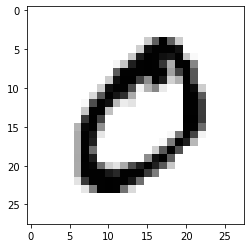

In [7]:
import matplotlib.pyplot as plt
index = 1

plt.imshow(x_train[index],cmap=plt.cm.gray_r)
plt.show()

To make things a little bit simpler (and faster!), we can extract from the data binary subsets, that only contain the data for two selected digits:

In [ ]:
import numpy as np

digit0=3
digit1=7
x_bin_train=x_train[np.logical_or(y_train==digit0,y_train==digit1)]
y_bin_train=y_train[np.logical_or(y_train==digit0,y_train==digit1)]

x_bin_test=x_test[np.logical_or(y_test==digit0,y_test==digit1)]
y_bin_test=y_test[np.logical_or(y_test==digit0,y_test==digit1)]

print("The first training datapoint now is: \n")
plt.imshow(x_bin_train[0],cmap=plt.cm.gray_r)
plt.show()
print(y_bin_train[0])

### Training a neural network

**a)** Learn different neural network models by varying the network architecture (i.e. number of layers and neurons in each layer) and the type of network (i.e. fully connected vs. convolutional). For each configuration, determine the time it takes to learn the model, and the accuracy on the test data. *Caution*: for some configurations, learning here can take a little while (several minutes).

**b)** Inspect some misclassified cases. Do they correspond to hard to recognize digits (also for the human reader)? (Hint: you can e.g. use the numpy where() function to extract the indices of the test cases that were misclassified: `misclass = np.where(test != predictions)` )

**c)** How do results (time and accuracy) change, depending on whether you consider an 'easy' binary task (e.g., distinguishing '1' and '0'), or a more difficult one (e.g., '4' vs. '5'). 

**d)** Identify one or several good configurations that give a reasonable combination of accuracy and runtime. Use these configurations to perform a full classification of the 10 classes in the original dataset (after split into train/test). Using `sklearn.metrics.confusion_matrix` you can get an overview of all combinations of true and predicted labels (see p. 298-299 in Müller & Guido). What does this tell you about which digits are easy, and which ones are difficult to recognize, and which ones are most easily confused?

### Cheating

We next investigate the capability of the neural networks to find a good model, knowing that a very accurate model exists. For this, we add some 'cheat info' to our data: we replace the first pixel value in the data matrix by a digit that simply contains a 0/1 encoding of the actual class label: 

In [ ]:
#adding cheating information to the training data:
cheatcol_train=np.array(y_bin_train) #making a copy of the original target array
cheatcol_train[cheatcol_train==digit0]=0  #re-coding the two classes as 0s and 1s
cheatcol_train[cheatcol_train==digit1]=1
x_bin_cheat_train = np.copy(x_bin_train)
x_bin_cheat_train[:,0,0] = cheatcol_train.reshape(len(cheatcol_train))

#adding cheating information to the testing data:
cheatcol_test=np.array(y_bin_test) #making a copy of the original target array
cheatcol_test[cheatcol_test==digit0]=0  #re-coding the two classes as 0s and 1s
cheatcol_test[cheatcol_test==digit1]=1
x_bin_cheat_test = np.copy(x_bin_test)
x_bin_cheat_test[:,0,0] = cheatcol_test.reshape(len(cheatcol_test))

The neural networks should, in principle, be able to construct a 100% accurate classifier for this data: we only have to 'learn' that only the first pixel in the data matters. 

**e)** Describe, briefly, how the weights of a (fully connected) network (with arbitrary number of layers) would have to be set, so that the resulting model is 100% accurate on this cheating data. This part of the exercise does not involve any Python code. Just give your answer in a short text.

**f)** Investigate how the accuracy improves in practice on this new dataset. Do you achieve 100% accuracy on the test set? If not, try to change the encoding in the cheat column: instead of representing digit1 with a 1, use a larger number, e.g. 250. Does that help? Why?

# Exercise 3 - Data preparation, exploration and feature engineering

In this exercise, you are going to investigate student dropout based on the dataset "churn2000.cvs". This is a real dataset, and there is no single "correct" way to use it (however, there are several wrong ones!). Your exercise is to explore one or more possible usecases, and document the one(s) you find the most fruitful/interesting.  Your work should probably include the steps below:

- An investigation of the data, using e.g. FACETs, Pandas, and/or whatever other tools you prefer. Can you find any interesting correlations? Are there problematic features or rows in the dataset?
- Handle missing data and possible outliers (in each case, consider what you want to do: Remove row? Remove column? Insert custom value?).
- Normalize/bin/create dummy variables where relevant. 
- Determine what you would like to predict, i.e. choose your target variable. Try formulating a specific usecase for your experiment (e.g. "Given a students perfomance in high school and first semester, what is the probability that he/she churns in the 2. semester?")
- Train a neural network and at least one other algorithm on the data. Find a good set of hyperparameters for each model. Do you think a neural network is suitable for this kind of problem? Why/why not?
- What features seem to be important for predicting whether a student is likely to drop out?

Warning: Make sure you carefully consider what information is available at the time where a prediction is to be made - for example, it doesn't make any sense to try to predict if a student churns in semester 1, if you include a feature which tells that this student churned in semester 2!  So depending on your specific usecase, you should probably remove some columns and/or rows before you train your model.

# Exercise 4: Reinforcement Learning

You can carry out this part of the project either in a jupyter notebook or in a google colab notebook - the latter option allows you to easily use the GPU, rather than the CPU, for training, which is MUCH faster! See these videos for how to get started with google colab notebooks: https://www.youtube.com/watch?v=inN8seMm7UI (for getting started) and https://www.youtube.com/watch?v=PitcORQSjNM (for using the GPU). At the end, you can simply merge the generated pdfs when you submit your project. 


In this final exercise, we are going to explore the concept of reinforcement learning by training a neural network to play a game of your own choice.

We will use the environments provided in OpenAI Gym https://gym.openai.com/ and also documented here: https://github.com/openai/gym/wiki

Instead of implementing Q-learning yourselves, you are welcome to simply run a pre-coded example.
You can look here for inspiration: https://github.com/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb 

In the exercise, toy around with the parameters, and see if you can optimize learning. You should also explain the basics of what is going on. Include some pictures of the animation, and report your score.

a) Give a short description of the rules and incentives in the game.

b) Run the code (either directly in the notebook or on Colab), and show how the training progresses, for example by taking screenshots and including them as pictures in the notebook.

c) Give a short description of what is going on in the code. This should include a description of the neural network, the inputs and outputs to the neural network, and the process of Q-learning.

d) Report the highest score your network was able to obtain. 